In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

READING THE CSV

In [ ]:
df = pd.read_csv('/content/fer2013.csv')
print(f"Total samples: {len(df)}")

Total samples: 7253


LOADING DATA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/fer2013.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (35887, 3)
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


BASIC STATISTICS

In [ ]:
print("\nBasic Stats:")
print(df.describe())
print("\nMissing values:", df.isnull().sum())


Basic Stats:
            emotion
count  35887.000000
mean       3.323265
std        1.873819
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        6.000000

Missing values: emotion    0
pixels     0
Usage      0
dtype: int64


CLASS DISTRIBUTION

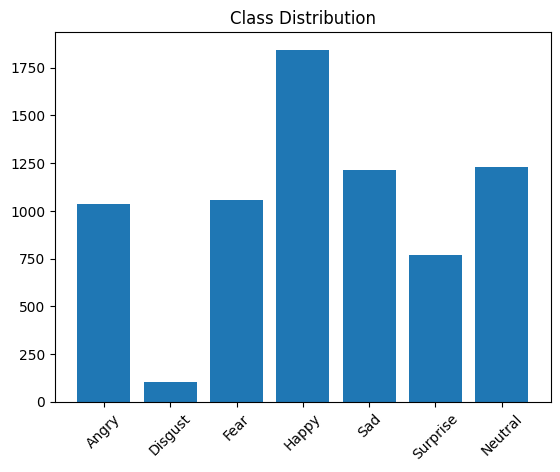

In [ ]:
emotion_counts = df['emotion'].value_counts().sort_index()
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
plt.bar(emotion_labels, emotion_counts)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

USAGE SPLIT ANALYSIS

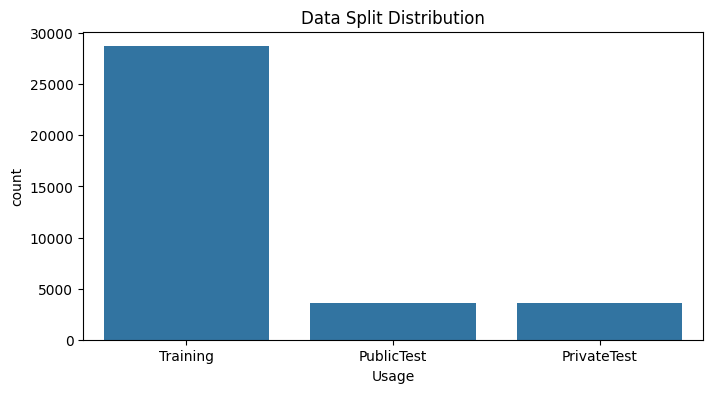

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Usage', data=df)
plt.title('Data Split Distribution')
plt.show()

PIXEL VALUE ANALYSIS

Pixel stats - Min: 11, Max: 210


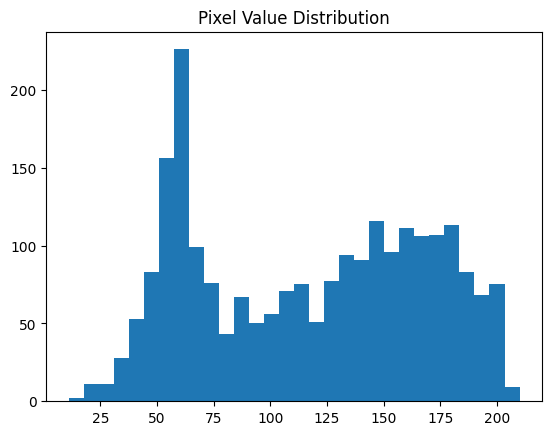

In [ ]:
# Analyze first image's pixel values
pixel_sample = list(map(int, df.iloc[0]['pixels'].split()))
print(f"Pixel stats - Min: {min(pixel_sample)}, Max: {max(pixel_sample)}")
plt.hist(pixel_sample, bins=30)
plt.title('Pixel Value Distribution')
plt.show()

SAMPLE IMAGES VISUALIZATION

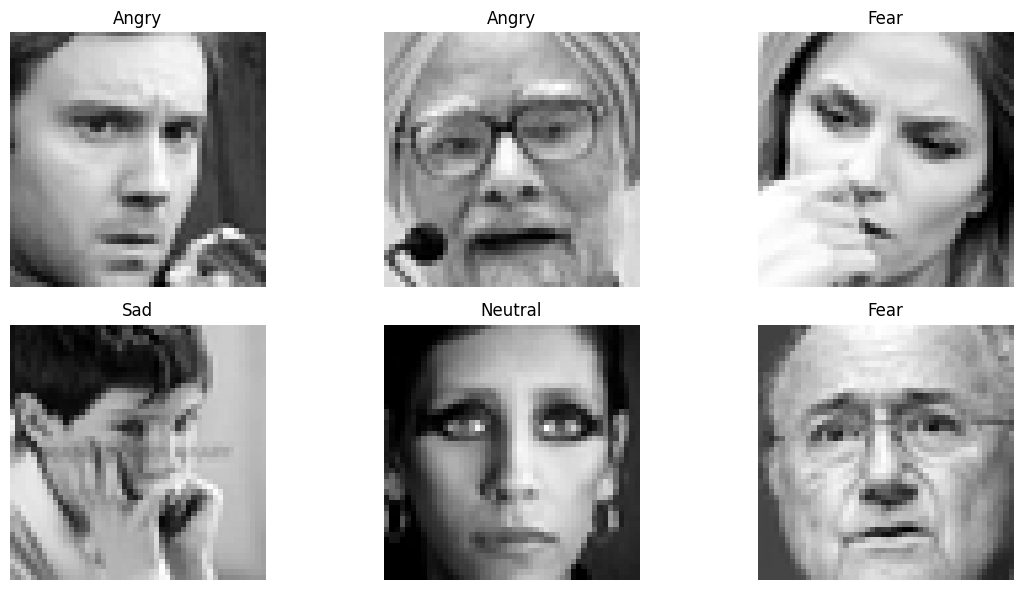

In [ ]:
def plot_sample_images(n=6):
    plt.figure(figsize=(12,6))
    for i in range(n):
        plt.subplot(2,3,i+1)
        pixels = np.array(df.iloc[i]['pixels'].split(), dtype='uint8').reshape(48,48)
        plt.imshow(pixels, cmap='gray')
        plt.title(emotion_labels[df.iloc[i]['emotion']])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images()

CLASS DISTRIBUTION PER SPLIT

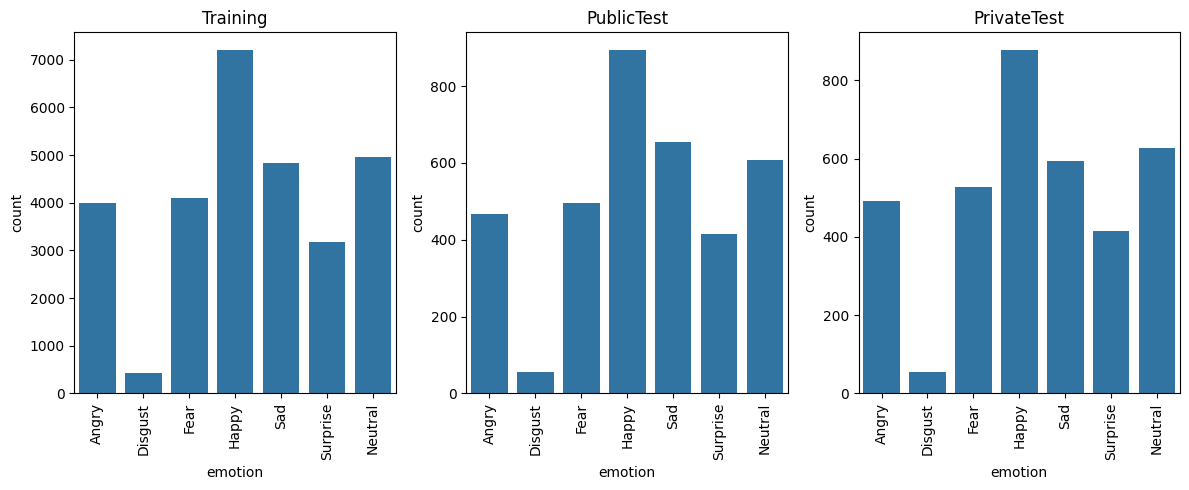

In [ ]:
plt.figure(figsize=(12,5))
for i, usage in enumerate(['Training', 'PublicTest', 'PrivateTest']):
    plt.subplot(1,3,i+1)
    subset = df[df['Usage']==usage]
    sns.countplot(x='emotion', data=subset)
    plt.xticks(ticks=range(7), labels=emotion_labels, rotation=90)
    plt.title(usage)
plt.tight_layout()
plt.show()

IMAGE SIZE ANALYSIS

In [ ]:
# Verify all images are 48x48
pixel_lengths = df['pixels'].apply(lambda x: len(x.split()))
print(f"Unique pixel counts: {pixel_lengths.unique()}")  # Should be 2304 (48*48)

Unique pixel counts: [2304]


EMOTION INTENSITY ANALYSIS

In [ ]:
def analyze_intensity(emotion_idx):
    subset = df[df['emotion']==emotion_idx]
    intensities = subset['pixels'].apply(lambda x: np.mean(list(map(int, x.split()))))
    print(f"{emotion_labels[emotion_idx]} intensity - Mean: {intensities.mean():.1f}, Std: {intensities.std():.1f}")

for i in range(7):
    analyze_intensity(i)

Angry intensity - Mean: 126.5, Std: 33.3
Disgust intensity - Mean: 135.1, Std: 32.3
Fear intensity - Mean: 135.4, Std: 32.4
Happy intensity - Mean: 129.1, Std: 32.0
Sad intensity - Mean: 121.0, Std: 33.5
Surprise intensity - Mean: 146.3, Std: 31.7
Neutral intensity - Mean: 123.9, Std: 33.2


CORRELATION BETWEEN EMOTION

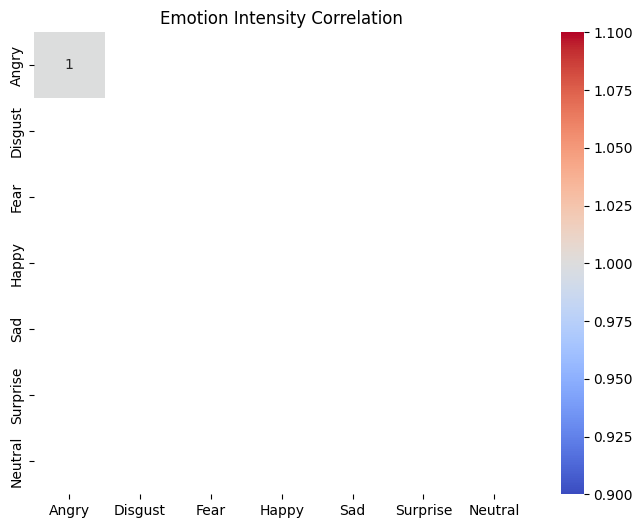

In [ ]:
# Create intensity features
intensity_df = pd.DataFrame()
for i in range(7):
    intensity_df[emotion_labels[i]] = df[df['emotion']==i]['pixels'].apply(
        lambda x: np.mean(list(map(int, x.split()))))

plt.figure(figsize=(8,6))
sns.heatmap(intensity_df.corr(), annot=True, cmap='coolwarm')
plt.title('Emotion Intensity Correlation')
plt.show()

PIXEL VALUE DISTRIBUTION BY EMOTION

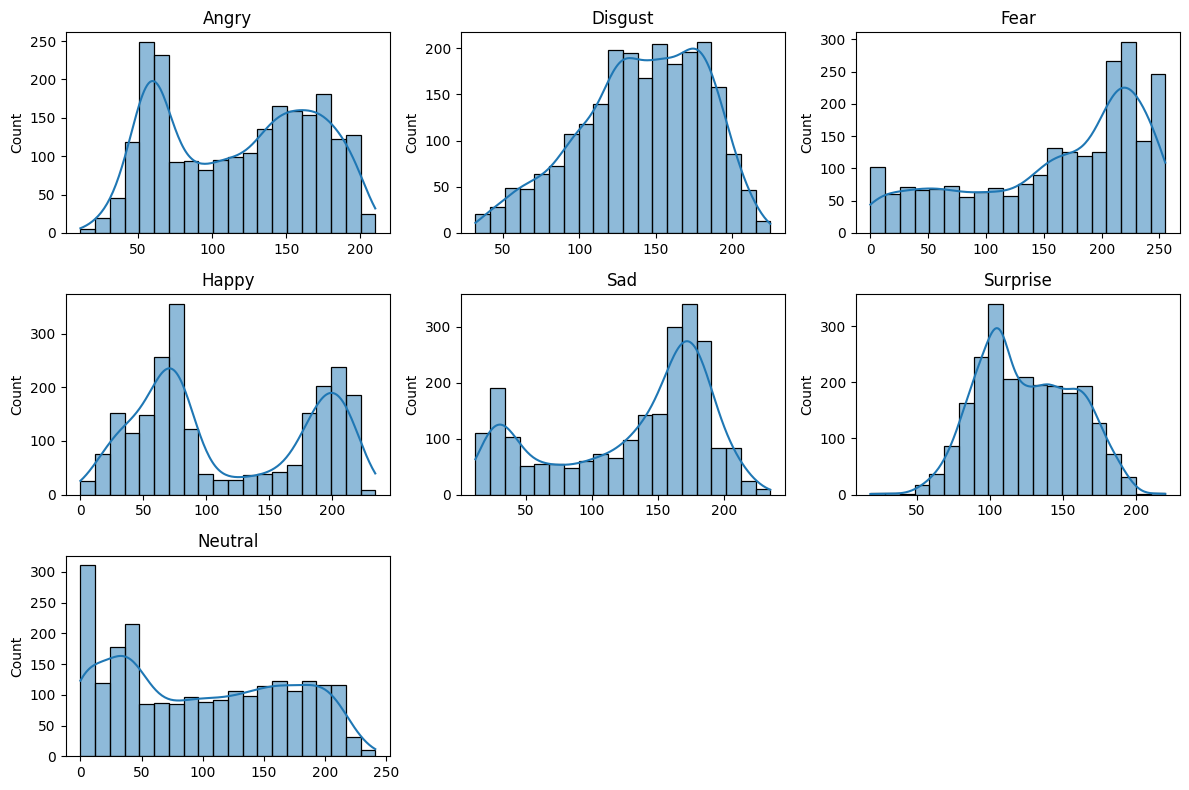

In [ ]:
plt.figure(figsize=(12,8))
for i in range(7):
    plt.subplot(3,3,i+1)
    sample_pixels = np.array(df[df['emotion']==i].iloc[0]['pixels'].split(), dtype='uint8')
    sns.histplot(sample_pixels, bins=20, kde=True)
    plt.title(emotion_labels[i])
plt.tight_layout()
plt.show()

DATA AUGMENTATION

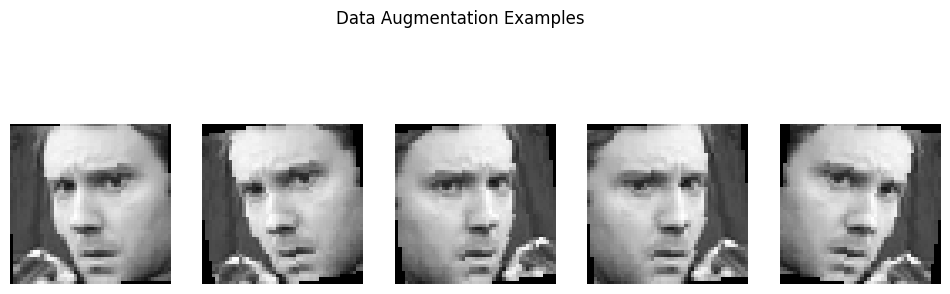

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

sample_img = np.array(df.iloc[0]['pixels'].split(), dtype='uint8').reshape(48,48)
plt.figure(figsize=(12,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    augmented = transform(sample_img).permute(1,2,0).numpy()
    plt.imshow(augmented.squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Data Augmentation Examples')
plt.show()

CLASS WEIGHTS

In [ ]:
class_weights = 1. / emotion_counts
class_weights = torch.FloatTensor(class_weights / class_weights.sum())
class_weights = class_weights.to(device)
print(class_weights)

tensor([0.0650, 0.6363, 0.0639, 0.0366, 0.0556, 0.0877, 0.0549])


SPLITTING

In [ ]:
train_df = df[df['Usage']=='Training']
val_df = df[df['Usage']=='PublicTest']
test_df = df[df['Usage']=='PrivateTest']
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 7252, Val: 0, Test: 0


In [ ]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array(self.data.iloc[idx]['pixels'].split(), dtype='uint8').reshape(48, 48, 1)
        pixels = np.repeat(pixels, 3, axis=2)  # RGB conversion
        emotion = self.data.iloc[idx]['emotion']
        if self.transform:
            pixels = self.transform(pixels)
        return pixels, emotion

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = FERDataset(train_df, train_transform)
val_dataset = FERDataset(val_df, val_transform)
test_dataset = FERDataset(test_df, val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

Batch shape: torch.Size([64, 3, 48, 48]), Labels: tensor([2, 0, 3, 3, 4])


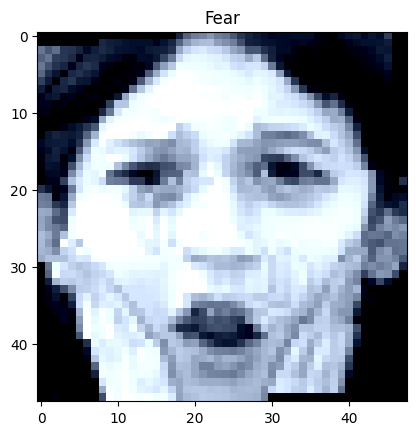

In [ ]:
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")
plt.imshow(images[0].permute(1,2,0).numpy() * 0.5 + 0.5)  # Denormalize
plt.title(emotion_labels[labels[0]])
plt.show()

In [ ]:
class EmotionResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = models.resnet18(pretrained=True)
        self.base.fc = nn.Linear(self.base.fc.in_features, 7)

    def forward(self, x):
        return self.base(x)

model = EmotionResNet().to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.6MB/s]


EmotionResNet(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
# Load dataset
df = pd.read_csv('/content/fer2013.csv')

# Verify data splits
if 'Usage' not in df.columns:
    raise ValueError("Missing 'Usage' column")
train_df = df[df['Usage'] == 'Training']
val_df = df[df['Usage'] == 'PublicTest']
test_df = df[df['Usage'] == 'PrivateTest']
if len(train_df)==0 or len(val_df)==0 or len(test_df)==0:
    raise ValueError("Empty data splits detected")

In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None, balance=True):
        self.data = dataframe
        self.transform = transform
        if balance:
            class_counts = self.data['emotion'].value_counts()
            self.samples_weights = (1. / class_counts)[self.data['emotion']].values

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array(self.data.iloc[idx]['pixels'].split(), dtype='uint8')
        image = pixels.reshape(48, 48, 1).repeat(3, axis=2)  # Convert to 3 channels
        emotion = self.data.iloc[idx]['emotion']
        if self.transform: image = self.transform(image)
        return image, emotion

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create datasets
train_data = FER2013Dataset(train_df, train_transform, balance=True)
val_data = FER2013Dataset(val_df, val_transform)
test_data = FER2013Dataset(test_df, val_transform)

# Create weighted sampler
sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_data.samples_weights,
    num_samples=len(train_data),
    replacement=True
)

# Initialize loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size, sampler=sampler)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

EMOTIONNET MODEL

In [ ]:
class EmotionNet(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.base_model = models.mobilenet_v2(pretrained=True).features
        self.conv1 = nn.Conv2d(1280, 512, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.conv1(x)
        x = self.pool(x)
        return self.fc(self.dropout(x.view(x.size(0), -1)))

model = EmotionNet().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 57.8MB/s]


LOSS FUNCTION

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean() if self.reduction=='mean' else focal_loss

criterion = FocalLoss()

TRAINING SETUP BY ADAM OPTIMIZER

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
best_val_acc = 0

TRAINING LOOP

In [ ]:
for epoch in range(10):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(model(images).data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100.*correct/total

    # The indentation of the next two lines was incorrect and fixed
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100.*correct/total
    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}%')

    if val_acc > best_val_acc:
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_acc = val_acc

Epoch 1: Train Loss: 0.5631, Acc: 65.10% | Val Loss: 0.7231, Acc: 56.12%
Epoch 2: Train Loss: 0.5429, Acc: 66.22% | Val Loss: 0.6885, Acc: 58.54%
Epoch 3: Train Loss: 0.5062, Acc: 68.16% | Val Loss: 0.7197, Acc: 58.23%
Epoch 4: Train Loss: 0.4945, Acc: 68.66% | Val Loss: 0.6954, Acc: 57.93%
Epoch 5: Train Loss: 0.4674, Acc: 70.54% | Val Loss: 0.6732, Acc: 59.99%
Epoch 6: Train Loss: 0.4509, Acc: 71.30% | Val Loss: 0.6857, Acc: 58.99%
Epoch 7: Train Loss: 0.4320, Acc: 72.17% | Val Loss: 0.7186, Acc: 57.70%
Epoch 8: Train Loss: 0.4079, Acc: 73.42% | Val Loss: 0.7104, Acc: 59.35%
Epoch 9: Train Loss: 0.3927, Acc: 74.41% | Val Loss: 0.7360, Acc: 58.04%
Epoch 10: Train Loss: 0.3582, Acc: 73.94% | Val Loss: 0.6760, Acc: 61.49%


CLASSIFICATION REPORT

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        all_preds.extend(torch.max(model(images), 1)[1].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

              precision    recall  f1-score   support

       Angry       0.51      0.54      0.52       491
     Disgust       0.69      0.73      0.71        55
        Fear       0.45      0.40      0.42       528
       Happy       0.85      0.80      0.82       879
         Sad       0.49      0.45      0.47       594
    Surprise       0.71      0.76      0.73       416
     Neutral       0.56      0.64      0.60       626

    accuracy                           0.61      3589
   macro avg       0.61      0.62      0.61      3589
weighted avg       0.61      0.61      0.61      3589



CONFUSION MATRIX

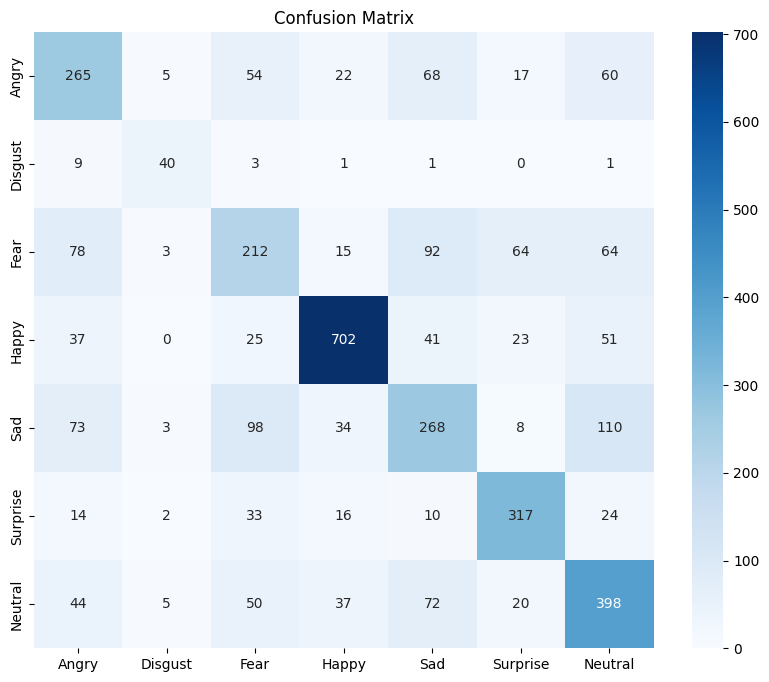

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(all_labels, all_preds),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.show()

DENORMALIZATION

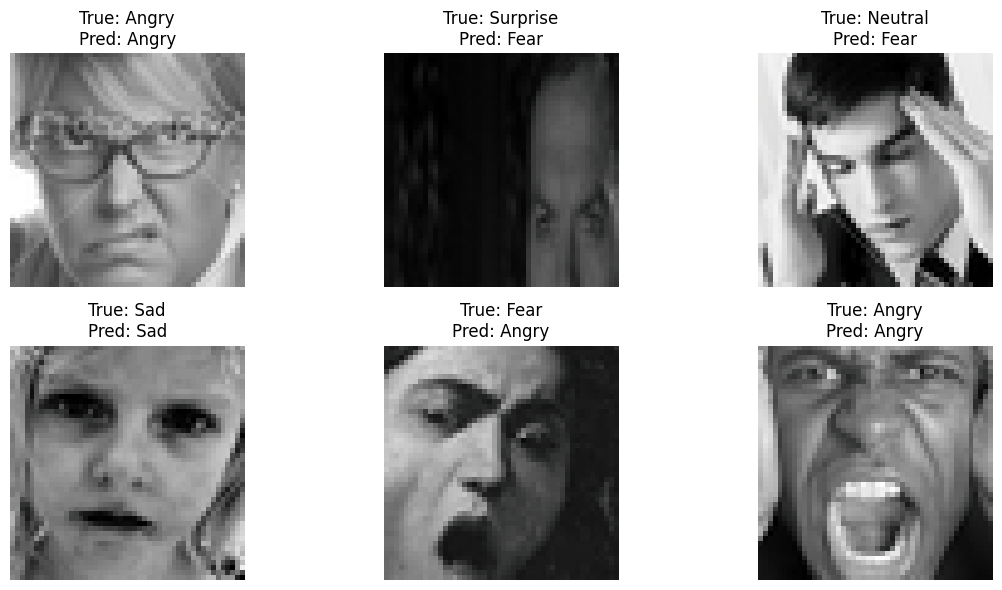

In [ ]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)
    return tensor * std + mean

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = outputs.max(1)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    # Squeeze the tensor to remove the batch dimension
    img = denormalize(images[i].unsqueeze(0)).cpu().squeeze(0).permute(1,2,0).numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f'True: {emotion_labels[labels[i].item()]}\nPred: {emotion_labels[preds[i].item()]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

TRAINING AND VALIDATION CURVE

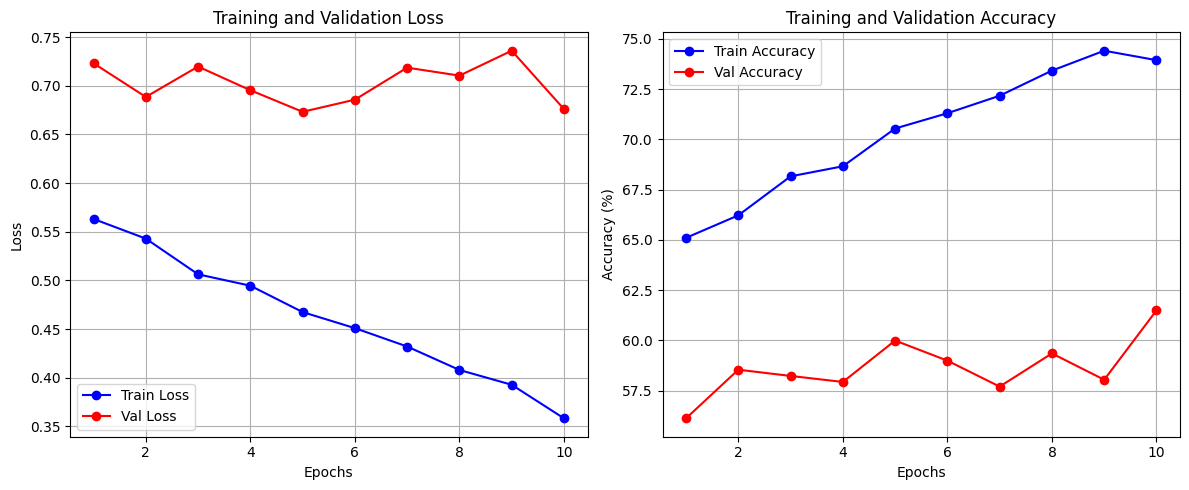

In [ ]:
import matplotlib.pyplot as plt

# Extract data from your training logs
epochs = range(1, 11)
train_loss = [0.5631, 0.5429, 0.5062, 0.4945, 0.4674, 0.4509, 0.4320, 0.4079, 0.3927, 0.3582]
val_loss = [0.7231, 0.6885, 0.7197, 0.6954, 0.6732, 0.6857, 0.7186, 0.7104, 0.7360, 0.6760]
train_acc = [65.10, 66.22, 68.16, 68.66, 70.54, 71.30, 72.17, 73.42, 74.41, 73.94]
val_acc = [56.12, 58.54, 58.23, 57.93, 59.99, 58.99, 57.70, 59.35, 58.04, 61.49]

# Create figure with two subplots
plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-o', label='Train Loss')
plt.plot(epochs, val_loss, 'r-o', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-o', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

IMPORTANT LIBRARIES FOR WEB CAMERA

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

WEB CAMERA TO PREDICT FACIAL EMOTION DETECTION

<IPython.core.display.Javascript object>

Prediction error: 'EmotionNet' object has no attribute 'predict'


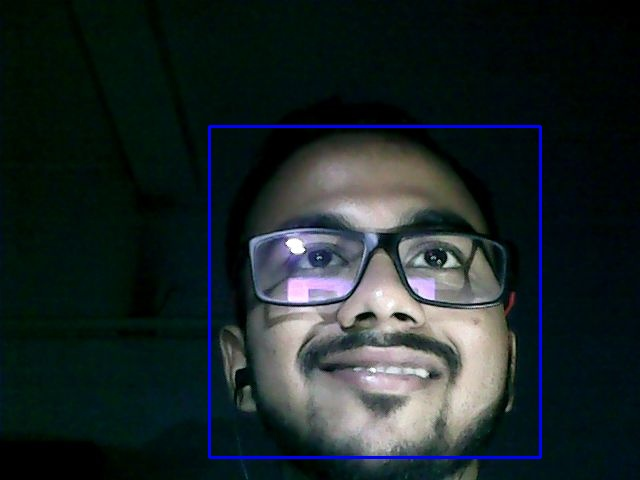

Saved to emotion.jpg


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import torch # Import PyTorch

# Assuming you saved your model using torch.save
# Load your CNN model
cnn_model = model # Assign model variable to cnn_model
# cnn_model.load_state_dict(torch.load('/content/best_model.pth')) # if using state_dict to save
cnn_model.eval() # Set to evaluation mode
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# ... (rest of the code remains the same) ...
def preprocess_cnn(face_roi):
    """Convert face ROI to CNN input format"""
    gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized / 255.0
    return np.expand_dims(normalized, axis=(0, -1))  # Shape (1, 48, 48, 1)

def js_to_image(js_reply):
    """Convert JS object to OpenCV image"""
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    return cv2.imdecode(jpg_as_np, flags=1)

def take_photo_with_emotion(filename='emotion.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Get photo
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face_roi = img[y:y+h, x:x+w]

        try:
            # CNN prediction
            cnn_input = preprocess_cnn(face_roi)
            pred = cnn_model.predict(cnn_input)[0]
            emotion = emotion_labels[np.argmax(pred)]
            confidence = max(pred)

            # Display result
            cv2.putText(img, f'{emotion} ({confidence:.2f})',
                        (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.9, (0, 255, 0), 2)
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            continue

    # Save and display
    cv2.imwrite(filename, img)
    display(Image(filename))
    return filename

try:
    filename = take_photo_with_emotion()
    print(f"Saved to {filename}")
except Exception as err:
    print(f"Error: {str(err)}")

In [ ]:
from PIL import Image
import cv2
import torch.nn.functional as F # Import F for softmax

# Load the trained model
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        emotion = emotion_labels[predicted.item()]
        probabilities = F.softmax(outputs, dim=1).squeeze().cpu().numpy() # Now F is defined

    return emotion, probabilities

# Example usage
image_path = '/content/emotion.jpg'
emotion, probabilities = predict_emotion(image_path)
print(f'Predicted Emotion: {emotion}')
for emo, prob in zip(emotion_labels, probabilities):
    print(f'{emo}: {prob*100:.2f}%')

Predicted Emotion: Happy
Angry: 16.30%
Disgust: 0.04%
Fear: 17.12%
Happy: 40.53%
Sad: 15.86%
Surprise: 2.09%
Neutral: 8.06%


TEST CASE OF SAD

<IPython.core.display.Javascript object>

Prediction error: 'EmotionNet' object has no attribute 'predict'


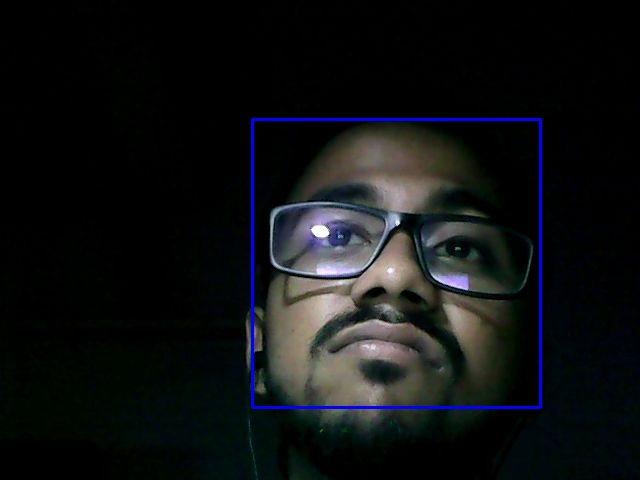

Saved to emotion.jpg


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import torch # Import PyTorch

# Assuming you saved your model using torch.save
# Load your CNN model
cnn_model = model # Assign model variable to cnn_model
# cnn_model.load_state_dict(torch.load('/content/best_model.pth')) # if using state_dict to save
cnn_model.eval() # Set to evaluation mode
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# ... (rest of the code remains the same) ...
def preprocess_cnn(face_roi):
    """Convert face ROI to CNN input format"""
    gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized / 255.0
    return np.expand_dims(normalized, axis=(0, -1))  # Shape (1, 48, 48, 1)

def js_to_image(js_reply):
    """Convert JS object to OpenCV image"""
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    return cv2.imdecode(jpg_as_np, flags=1)

def take_photo_with_emotion(filename='emotion.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Get photo
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face_roi = img[y:y+h, x:x+w]

        try:
            # CNN prediction
            cnn_input = preprocess_cnn(face_roi)
            pred = cnn_model.predict(cnn_input)[0]
            emotion = emotion_labels[np.argmax(pred)]
            confidence = max(pred)

            # Display result
            cv2.putText(img, f'{emotion} ({confidence:.2f})',
                        (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.9, (0, 255, 0), 2)
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            continue

    # Save and display
    cv2.imwrite(filename, img)
    display(Image(filename))
    return filename

try:
    filename = take_photo_with_emotion()
    print(f"Saved to {filename}")
except Exception as err:
    print(f"Error: {str(err)}")

In [ ]:
from PIL import Image
import cv2
import torch.nn.functional as F # Import F for softmax

# Load the trained model
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        emotion = emotion_labels[predicted.item()]
        probabilities = F.softmax(outputs, dim=1).squeeze().cpu().numpy() # Now F is defined

    return emotion, probabilities

# Example usage
image_path = '/content/emotion.jpg'
emotion, probabilities = predict_emotion(image_path)
print(f'Predicted Emotion: {emotion}')
for emo, prob in zip(emotion_labels, probabilities):
    print(f'{emo}: {prob*100:.2f}%')

Predicted Emotion: Sad
Angry: 9.52%
Disgust: 0.00%
Fear: 13.56%
Happy: 33.52%
Sad: 33.75%
Surprise: 0.23%
Neutral: 9.41%


TEST CASE OF SAD

<IPython.core.display.Javascript object>

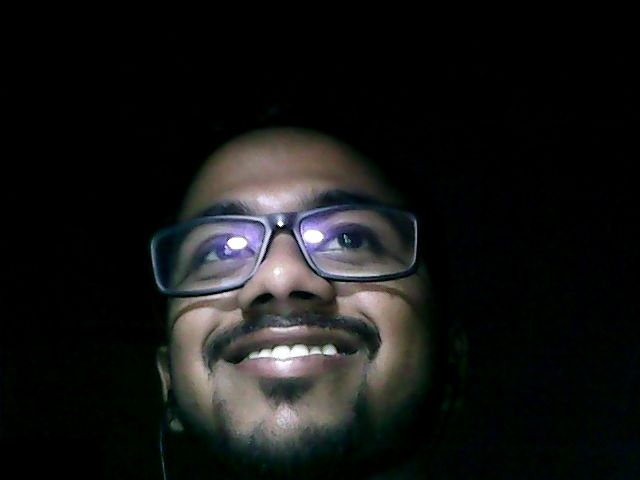

Saved to emotion.jpg


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import torch # Import PyTorch

# Assuming you saved your model using torch.save
# Load your CNN model
cnn_model = model # Assign model variable to cnn_model
# cnn_model.load_state_dict(torch.load('/content/best_model.pth')) # if using state_dict to save
cnn_model.eval() # Set to evaluation mode
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# ... (rest of the code remains the same) ...
def preprocess_cnn(face_roi):
    """Convert face ROI to CNN input format"""
    gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized / 255.0
    return np.expand_dims(normalized, axis=(0, -1))  # Shape (1, 48, 48, 1)

def js_to_image(js_reply):
    """Convert JS object to OpenCV image"""
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    return cv2.imdecode(jpg_as_np, flags=1)

def take_photo_with_emotion(filename='emotion.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Get photo
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face_roi = img[y:y+h, x:x+w]

        try:
            # CNN prediction
            cnn_input = preprocess_cnn(face_roi)
            pred = cnn_model.predict(cnn_input)[0]
            emotion = emotion_labels[np.argmax(pred)]
            confidence = max(pred)

            # Display result
            cv2.putText(img, f'{emotion} ({confidence:.2f})',
                        (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.9, (0, 255, 0), 2)
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            continue

    # Save and display
    cv2.imwrite(filename, img)
    display(Image(filename))
    return filename

try:
    filename = take_photo_with_emotion()
    print(f"Saved to {filename}")
except Exception as err:
    print(f"Error: {str(err)}")

In [ ]:
from PIL import Image
import cv2
import torch.nn.functional as F # Import F for softmax

# Load the trained model
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        emotion = emotion_labels[predicted.item()]
        probabilities = F.softmax(outputs, dim=1).squeeze().cpu().numpy() # Now F is defined

    return emotion, probabilities

# Example usage
image_path = '/content/emotion.jpg'
emotion, probabilities = predict_emotion(image_path)
print(f'Predicted Emotion: {emotion}')
for emo, prob in zip(emotion_labels, probabilities):
    print(f'{emo}: {prob*100:.2f}%')

Predicted Emotion: Happy
Angry: 5.42%
Disgust: 0.01%
Fear: 7.09%
Happy: 54.99%
Sad: 22.11%
Surprise: 0.65%
Neutral: 9.73%


TEST CASE OF ANGRY

<IPython.core.display.Javascript object>

Prediction error: 'EmotionNet' object has no attribute 'predict'


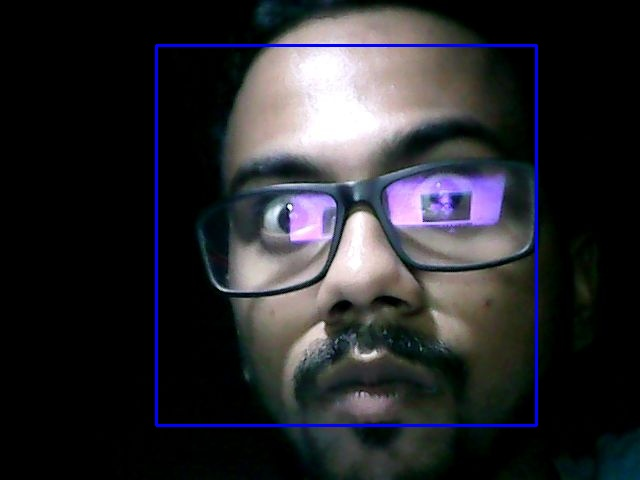

Saved to emotion.jpg


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import torch # Import PyTorch

# Assuming you saved your model using torch.save
# Load your CNN model
cnn_model = model # Assign model variable to cnn_model
# cnn_model.load_state_dict(torch.load('/content/best_model.pth')) # if using state_dict to save
cnn_model.eval() # Set to evaluation mode
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# ... (rest of the code remains the same) ...
def preprocess_cnn(face_roi):
    """Convert face ROI to CNN input format"""
    gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized / 255.0
    return np.expand_dims(normalized, axis=(0, -1))  # Shape (1, 48, 48, 1)

def js_to_image(js_reply):
    """Convert JS object to OpenCV image"""
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    return cv2.imdecode(jpg_as_np, flags=1)

def take_photo_with_emotion(filename='emotion.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Get photo
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face_roi = img[y:y+h, x:x+w]

        try:
            # CNN prediction
            cnn_input = preprocess_cnn(face_roi)
            pred = cnn_model.predict(cnn_input)[0]
            emotion = emotion_labels[np.argmax(pred)]
            confidence = max(pred)

            # Display result
            cv2.putText(img, f'{emotion} ({confidence:.2f})',
                        (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.9, (0, 255, 0), 2)
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            continue

    # Save and display
    cv2.imwrite(filename, img)
    display(Image(filename))
    return filename

try:
    filename = take_photo_with_emotion()
    print(f"Saved to {filename}")
except Exception as err:
    print(f"Error: {str(err)}")

In [ ]:
from PIL import Image
import cv2
import torch.nn.functional as F # Import F for softmax

# Load the trained model
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        emotion = emotion_labels[predicted.item()]
        probabilities = F.softmax(outputs, dim=1).squeeze().cpu().numpy() # Now F is defined

    return emotion, probabilities

# Example usage
image_path = '/content/emotion.jpg'
emotion, probabilities = predict_emotion(image_path)
print(f'Predicted Emotion: {emotion}')
for emo, prob in zip(emotion_labels, probabilities):
    print(f'{emo}: {prob*100:.2f}%')

Predicted Emotion: Angry
Angry: 38.00%
Disgust: 0.11%
Fear: 22.85%
Happy: 7.01%
Sad: 20.63%
Surprise: 0.15%
Neutral: 11.24%


TEST CASE OF FEAR


<IPython.core.display.Javascript object>

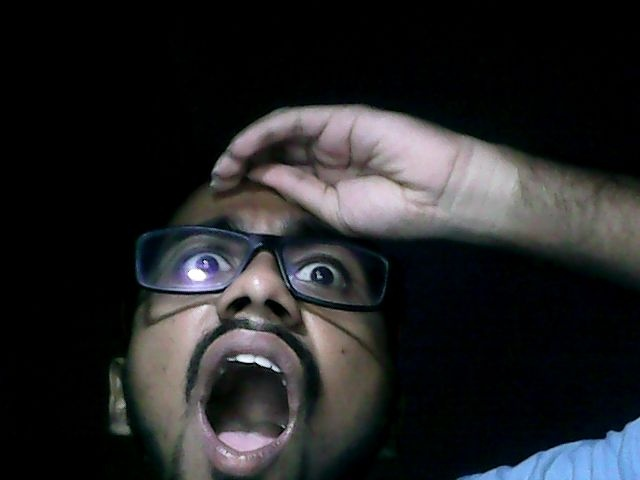

Saved to emotion.jpg


In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import torch # Import PyTorch

# Assuming you saved your model using torch.save
# Load your CNN model
cnn_model = model # Assign model variable to cnn_model
# cnn_model.load_state_dict(torch.load('/content/best_model.pth')) # if using state_dict to save
cnn_model.eval() # Set to evaluation mode
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# ... (rest of the code remains the same) ...
def preprocess_cnn(face_roi):
    """Convert face ROI to CNN input format"""
    gray = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized / 255.0
    return np.expand_dims(normalized, axis=(0, -1))  # Shape (1, 48, 48, 1)

def js_to_image(js_reply):
    """Convert JS object to OpenCV image"""
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    return cv2.imdecode(jpg_as_np, flags=1)

def take_photo_with_emotion(filename='emotion.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)

    # Get photo
    data = eval_js('takePhoto({})'.format(quality))
    img = js_to_image(data)

    # Detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face_roi = img[y:y+h, x:x+w]

        try:
            # CNN prediction
            cnn_input = preprocess_cnn(face_roi)
            pred = cnn_model.predict(cnn_input)[0]
            emotion = emotion_labels[np.argmax(pred)]
            confidence = max(pred)

            # Display result
            cv2.putText(img, f'{emotion} ({confidence:.2f})',
                        (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.9, (0, 255, 0), 2)
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            continue

    # Save and display
    cv2.imwrite(filename, img)
    display(Image(filename))
    return filename

try:
    filename = take_photo_with_emotion()
    print(f"Saved to {filename}")
except Exception as err:
    print(f"Error: {str(err)}")

In [ ]:
from PIL import Image
import cv2
import torch.nn.functional as F # Import F for softmax

# Load the trained model
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def predict_emotion(image_path):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        emotion = emotion_labels[predicted.item()]
        probabilities = F.softmax(outputs, dim=1).squeeze().cpu().numpy() # Now F is defined

    return emotion, probabilities

# Example usage
image_path = '/content/emotion.jpg'
emotion, probabilities = predict_emotion(image_path)
print(f'Predicted Emotion: {emotion}')
for emo, prob in zip(emotion_labels, probabilities):
    print(f'{emo}: {prob*100:.2f}%')

Predicted Emotion: Fear
Angry: 7.99%
Disgust: 0.11%
Fear: 48.20%
Happy: 11.17%
Sad: 24.86%
Surprise: 6.36%
Neutral: 1.30%


GRAND CAMERA

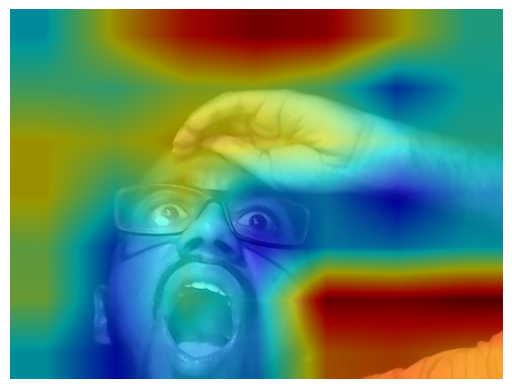

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load model and setup (same as before)
model = EmotionNet().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Choose the target layer (last convolutional layer)
# Get the last convolutional layer from the base_model
target_layer = model.base_model[-5]

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load image
image_path = '/content/emotion.jpg'
original_image = Image.open(image_path)
input_tensor = transform(original_image).unsqueeze(0).to(device) # Move input to device


# Hook to get feature maps and gradients
class FeatureExtractor:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        target_layer.register_backward_hook(self.save_gradient)
        # Pass input through the base model to get to the target layer
        output = self.model.base_model(x)
        self.activations = output

        # Apply other operations to get to the final model output
        x = self.model.conv1(output)  # Apply the conv1 layer
        x = self.model.pool(x)       # Apply the pooling layer
        x = torch.flatten(x, 1)   # Flatten the output
        x = self.model.fc(x)        # Apply the final fully connected layer
        return x  # Return the final model output

# Grad-CAM computation
def grad_cam(input_tensor, model, target_layer, target_class=None):
    extractor = FeatureExtractor(model, target_layer)
    output = extractor(input_tensor)

    if target_class is None:
        target_class = output.argmax(dim=1)

    output[0, target_class.item()].backward(retain_graph=True) # Get item from target_class

    gradients = extractor.gradients.data.cpu().numpy()[0]
    activations = extractor.activations.data.cpu().numpy()[0]

    pooled_gradients = np.mean(gradients, axis=(1, 2))

    # Fix: Iterate over the correct range (pooled_gradients length)
    for i in range(pooled_gradients.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


# Generate and visualize heatmap
heatmap = grad_cam(input_tensor, model, target_layer)

# Resize heatmap to original image size
heatmap_resized = cv2.resize(heatmap, (original_image.width, original_image.height))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Superimpose heatmap on original image
heatmap_colored_transparency = 0.6
superimposed_image = cv2.addWeighted(np.array(original_image), 1 - heatmap_colored_transparency, heatmap_colored, heatmap_colored_transparency, 0)

# Display the result
plt.imshow(cv2.cvtColor(superimposed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()